In [1]:
from utils.bmds import BMDSTrainer
from utils.nn import create_mlp_layers
from utils.time import timeit
import torch
from sklearn.neighbors import BallTree
from utils.preprocessing import check_tensor
from utils.distributions import exponential_log_prob
from typing import Any, Optional, Callable
from torch import nn
from abc import abstractmethod
import numpy as np
import torchvision
from tqdm import tqdm
import numpy as np
from multiprocessing import Pool
from scipy.spatial import KDTree

/usr/local/lib/python3.10/dist-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/usr/local/lib/python3.10/dist-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
n = 200
k = 1000
d_latent = 2
d = 10
noise_coef = 1e-10
batch_size = 1000

In [3]:
eps = 1e-10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class BaseBMDS(nn.Module):
    default_create_layers_kwargs: dict[str, Any] = {
        'activation': 'PReLU',
        'use_batch_norm': False,
        'last_layer_activation':  True,
        'last_layer_batch_norm': True,
    }

    def __init__(
        self,
        input_dim: int,
        n: int,
        *,
        n_layers: int = 2,
        hidden_dim: int = 1000,
        embedding_dim: int = 100,
        create_layers: Optional[Callable[..., list[nn.Module]]] = None,
        device: torch.device = DEVICE,
        **kwargs: Any,
    ):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n = n

        if create_layers is None:
            create_layers = create_mlp_layers
            kwargs = {**self.default_create_layers_kwargs, **kwargs}

        head_layers = create_layers(input_dim, [hidden_dim] * (n_layers - 1), hidden_dim, **kwargs)

        self.head = nn.Sequential(*head_layers).to(device)

        self.mu = nn.Parameter(torch.randn(hidden_dim, embedding_dim, device=device) / hidden_dim)
        self.sigma = nn.Parameter(torch.randn(hidden_dim, embedding_dim, device=device) / hidden_dim)

    def forward(self, inp):
        head = self.head(inp)
        return head @ self.mu, (head.pow(2) @ self.sigma.pow(2)).pow(0.5)
    
    def loss(self, batch):
        idx1, idx2, true_dist_sqr = batch.values()

        head1, head2 = self.head(self.get_inp(idx1)), self.head(self.get_inp(idx2))
        x = head1 - head2

        mu = x @ self.mu
        sigma = (x.pow(2) @ self.sigma.pow(2)).pow(0.5)
        
        dist_sqr = (mu + torch.randn_like(sigma) * sigma).pow(2).mean(1)
        
        log_prob = exponential_log_prob(true_dist_sqr, dist_sqr).mean()
        reg = self.reg(head1, head2)
        
        return {'loss': -log_prob + reg, 'log_prob': log_prob, 'reg': reg, **self.get_metrics()}

    def reg(self, mu, sigma):
        return (torch.log(self.mu.var(0) + self.sigma.pow(2).mean(0) + eps).sum() * self.hidden_dim - torch.log(self.sigma.pow(2) + eps).sum()) / self.n / 2

    def dist_sqr(self, diffs):
        return diffs.pow(2).mean(-1)
        
    @abstractmethod
    def get_inp(self, idx):
        raise NotImplementedError

    def get_metrics(self):
        snfs = sorted((self.mu / self.sigma).pow(2).mean(0))[::-1]
        scales = sorted(self.mu.pow(2).mean(0) + self.sigma.pow(2).mean(0))[::-1]
        return {**{f"snf # {i + 1}": snfs[i] for i in list(range(5)) + list(range(10, 100, 10))}, **{f"scale # {i + 1}": scales[i] for i in list(range(5)) + list(range(10, 100, 10))}}


class DefaultBMDS(BaseBMDS):
    def __init__(
            self,
            dist,
            *args,
            device: torch.device = DEVICE,
            **kwargs: Any,
    ):
        print(args)
        super().__init__(*args, device=device, **kwargs)
        
        self.dist_sqr = check_tensor(dist, device=device).pow(2)
        
    def get_inp(self, idx):
        return self.dist_sqr[idx]


class NeighborsBMDS(BaseBMDS):
    def __init__(
            self,
            dist,
            neighbors,
            batch_size,
            *args,
            device: torch.device = DEVICE,
            **kwargs: Any,
    ):
        super().__init__(*args, **kwargs)
        
        self.dist_sqr = check_tensor(dist, device=device).pow(2)
        self.neighbors = check_tensor(neighbors, device=device)
        
        self.batch_size = batch_size
        self.obj_idx = torch.arange(batch_size, device=device).repeat(dist.shape[1], 1).T.reshape(-1)

    def get_inp(self, idx):
        neighbors_idx = self.neighbors[idx].reshape(-1)
        neighbors_dist_sqr = self.dist_sqr[idx].reshape(-1)
        
        return torch.sparse_coo_tensor(
            indices=torch.stack((self.obj_idx, neighbors_idx)),
            values=neighbors_dist_sqr,
            size=(self.batch_size, self.input_dim),
        )


class RandomObjectsBMDS(BaseBMDS):
    def __init__(self, dist, *args, device: torch.device = DEVICE, **kwargs):
        super().__init__(*args, **kwargs)

        self.dist = check_tensor(dist, device=device)
    
    def get_inp(self, idx):
        return self.dist[idx]


class PeriodicBMDS(DefaultBMDS):
    def __init__(
        self,
        *args,
        d_periodic: int = 20,
        device: torch.device = DEVICE,
        **kwargs,
    ):
        super().__init__(*args, device=device, **kwargs)

        self.d_periodic = d_periodic
        self.periodic_scales = nn.Parameter(torch.randn(d_periodic, device=device), requires_grad=True)

    def reg(self, head1, head2):
        kl_term = super().reg(head1, head2)
        head = torch.cat((head1, head2), 0)
        periodic_mu, periodic_sigma = head @ self.mu[:, -2 * self.d_periodic], (head.pow(2) @ self.sigma[:, -2 * self.d_periodic].pow(2)).pow(0.5)
        periodic_samples = periodic_mu + torch.randn_like(periodic_sigma) * periodic_sigma
        scales = periodic_samples.reshape(-1, self.d_periodic, 2).pow(2).sum(-1).pow(0.5)
        return kl_term + (scales - self.periodic_scales).pow(2).mean(0).sum()

    def get_metrics(self):
        return {**{f"periodic scale #{i + 1}": scale for i, scale in enumerate(torch.abs(self.periodic_scales))}, **super().get_metrics()}

    
class NeighborsDataset(torch.utils.data.Dataset):
    def __init__(self, dist, neighbors):
        super().__init__()
        
        self.object_idx = torch.arange(dist.shape[0]).repeat(dist.shape[1], 1).T.reshape(-1)
        self.neighbors_idx = check_tensor(neighbors, dtype=torch.int64).reshape(-1)
        self.dist_sqr = (check_tensor(dist).reshape(-1) / dist.max()).pow(2)
        
    def __len__(self):
        return self.dist_sqr.shape[0]
    
    def __getitem__(self, idx):
        return {'idx1': self.object_idx[idx], 'idx2': self.neighbors_idx[idx], 'dist_sqr': self.dist_sqr[idx]}
    
    
def create_generator(dataset: torch.utils.data.Dataset, batch_size: int = 128, shuffle: bool = True, drop_last: bool = True, **kwargs):
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, **kwargs)
    while True:
        yield from loader

In [4]:
x = torch.randn(200, 1)
t = torch.rand(200, 1) * 6.28

dist = ((x - x[:, None]).pow(2).sum(-1) + 4 * torch.sin((t - t[:, None]) / 2).pow(2).sum(-1)).pow(0.5)

y = torch.sin(t)
z = torch.cos(t)

data = torch.cat((x, y, z), 1)

dist - (data - data[:, None]).pow(2).sum(-1).pow(0.5)

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
         -1.1921e-07,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.1921e-07,
          0.0000e+00,  1.1921e-07],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          1.1921e-07,  0.0000e+00]])

In [9]:
x = torch.randn(200, 1)
t = torch.rand(200, 1) * 6.28

dist = ((x - x[:, None]).pow(2).sum(-1) + 4 * torch.sin((t - t[:, None]) / 2).pow(2).sum(-1)).pow(0.5)

dataset = NeighborsDataset(dist, torch.arange(len(dist)).repeat(len(dist), 1))
bmds = PeriodicBMDS(dist, len(dist), len(dataset), hidden_dim=200, n_layers=3)
bmds_trainer = BMDSTrainer(bmds, lr=1e-3)

bmds_trainer.train(create_generator(dataset, batch_size=100), project_name='bmds cylinder', experiment_name='first trial', total_iters=100000)

/home/coder/project/utils/preprocessing.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(t, dtype=dtype, **kwargs)


(200, 40000)


In [ ]:
mu, sigma = bmds(dist.pow(2).to(DEVICE))

In [ ]:
mask = mu.pow(2).mean(0) > 1
mask.sum()

tensor(3, device='cuda:0')

In [ ]:
embedding = mu[:, mask].detach().cpu()
np.savez('embedding.npz', embedding=embedding)

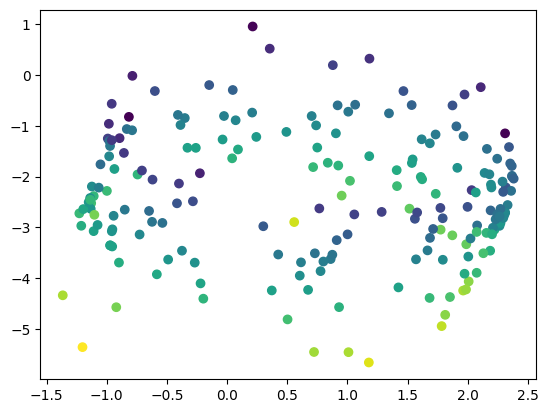

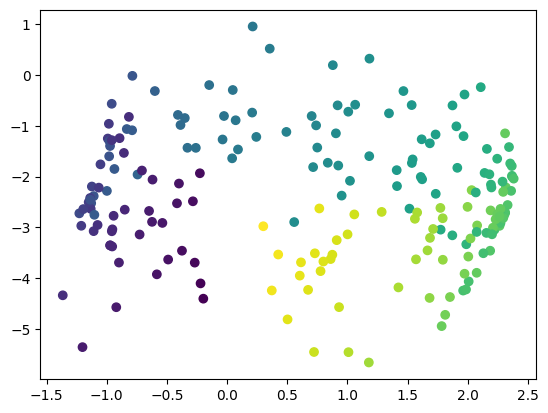

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(*embedding.T[:2], c=x[:, 0])

plt.figure()
plt.scatter(*embedding.T[:2], c=t[:, 0])

In [ ]:
mu.pow(2).mean(0)

tensor([3.7329e-06, 7.7044e-07, 7.8948e-08, 7.3820e-07, 1.0972e-06, 4.7054e-07,
        4.6193e-07, 1.9957e-08, 3.9480e-07, 5.9488e-07, 2.1593e-06, 2.0266e-07,
        2.9082e-07, 1.1215e-07, 3.4286e-07, 4.7184e-08, 9.1959e-08, 6.2232e-07,
        3.6631e-07, 2.5282e-08, 2.3676e-07, 2.0970e-07, 8.1505e-07, 2.4250e-06,
        1.0753e-06, 1.8947e-06, 3.9999e-08, 1.6225e-07, 7.0738e-08, 1.2535e-08,
        1.4650e-06, 2.1425e+00, 7.5619e-07, 4.4373e-08, 1.9001e-07, 5.0590e-07,
        5.8102e-08, 4.0886e-07, 2.2898e-06, 1.1060e-07, 3.4114e-08, 2.0316e-06,
        1.6542e-06, 6.8465e-07, 7.3379e+00, 5.9379e-08, 6.6883e-09, 8.8840e-08,
        5.3341e-06, 4.5835e-07, 1.4439e-07, 8.4198e-07, 1.1662e-07, 4.1104e-07,
        2.7442e+01, 1.4673e-07, 2.3672e-06, 3.6235e-07, 8.2723e-10, 8.6196e-08,
        5.2747e-06, 2.6084e-07, 6.1258e-07, 1.4021e-07, 2.1259e-08, 1.4658e-08,
        4.7294e-07, 1.1373e-07, 2.1672e-08, 5.7750e-08, 3.6522e-07, 9.8537e-07,
        3.3583e-06, 2.1905e-07, 3.5674e-

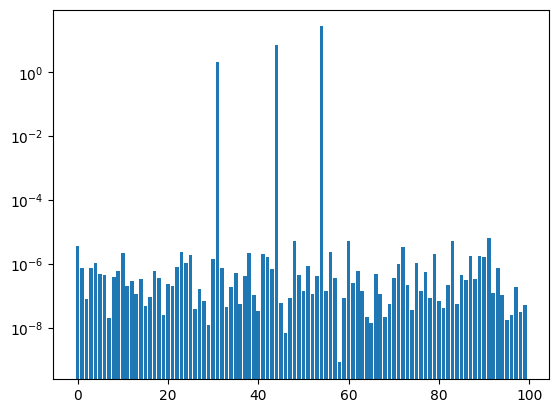

In [ ]:
plt.bar(np.arange(100), mu.pow(2).mean(0).detach().cpu())
plt.yscale('log')

(array([ 4.,  9., 15., 32., 47., 36., 28., 19.,  7.,  3.]),
 array([-5.6601243 , -4.9988246 , -4.33752441, -3.67622471, -3.014925  ,
        -2.3536253 , -1.69232535, -1.03102541, -0.3697257 ,  0.291574  ,
         0.95287359]),
 <BarContainer object of 10 artists>)

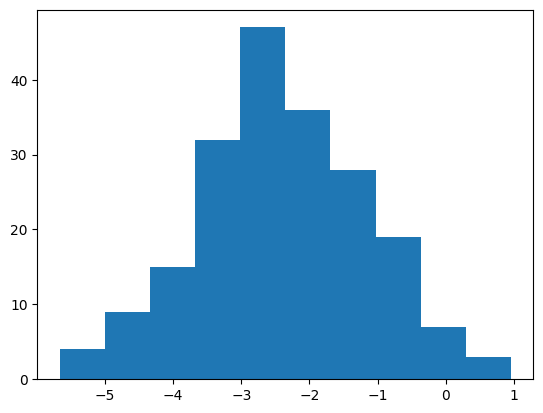

In [ ]:
plt.hist(embedding[:, 1])

In [ ]:
plt.bar(range(50), bmds.periodic_scales.pow(2).detach().cpu())

AttributeError: 'PeriodicBMDS' object has no attribute 'periodic_scales'

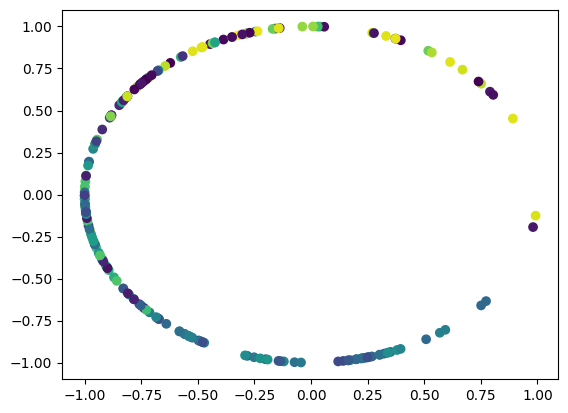

In [ ]:
plt.scatter(torch.sin(embedding[:, 1]), torch.cos(embedding[:, 1]), c=t[:, 0])